# Notebook para estudo e explicação de polarização de transistores TBJ

Nesse notebook estudaremos a polarização do transistor bipolar de junção. Como exemplo utilizaremos o transistor para propósito geral QN2222a. O datasheet do transistor em questão (fabricado pela farchild) é encontrado em [link][link], outros datasheets (com as mesmas informações) podem ser encontrados facilmente em outros sites na internet (you can google it). O modelo SPICE do transistor também está no data sheet, e replicado logo abaixo:

.model Q2N2222 
NPN(Is = 14.34f Xti = 3 Eg = 1.11 Vaf = 74.03 Bf = 255.9 Ne = 1.307 Ise = 14.34 Ikf = .2847 Xtb = 1.5 Br = 6.092 Isc = 0 Ikr = 0 Rc = 1 Cjc = 7.306p Mjc = .3416 Vjc = .75 Fc = .5 Cje = 22.01p Mje = .377 Vje = .75 Tr = 46.91n Tf = 411.1p Itf = .6 Vtf = 1.7 Xtf = 3 Rb = 10)

In [1]:
import numpy as np # Carrega numpy para matemática computacional
import matplotlib.pyplot as plt # Carrega pyplot para plotar gráficos

np.set_printoptions(precision=6)
float_formatter = lambda x: "%.6f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

In [2]:
k=1.38064852e-23 # Constante de Boltzmann
q=1.60217662e-19 # Carga do elétron (portador)

In [3]:
def ctok(c):
    return c+273.15

In [4]:
def vt_val(temp):
    return k*ctok(temp)/q

In [5]:
print('%3.6f' % vt_val(27))

0.025865


In [6]:
print('%3.6f' % vt_val(77))

0.030174


___________
Para compreender o efeito da temperatura, primeiramente veja que, ao aumentar a temperatura o termo da função exponencial diminui, fazendo com que a função torne-se *mais lenta*. Portanto, assumindo valores mais baixos. Isso significa que para os mesmos valores de polarização do transistor, o aumento da temperatura faz com que a corrente de coletor diminua.

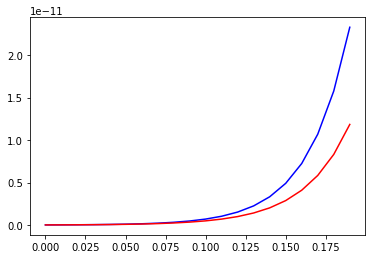

In [7]:
plt.figure(num=3)

x=np.arange(0, 20, dtype=float)/100

# plt.subplot(211)
plt.plot(x,14.3e-15*np.exp(x/vt_val(25)), color='blue')
# plt.subplot(212)
plt.plot(x,14.3e-15*np.exp(x/vt_val(55)), color='red')

___
Quando polarizamos o transistor diretamente em tensão (na base: Vx=Vb=Vbe). a variação da tempertatura exerce figura muito importante na variação da corrente de coletor (Ic) devido à modificação direta de parâmetros do transistor (notadamente $\beta$). ISso acontece pois apesar de Ic depender exponencialmente de Vbe, sua relação com a corrente de base Ib não pode ser negligenciada. Os circuitos de polarização devem portanto, reduzir esses efeitos da variação da temperatura no transistor.

## Exemplo 01
### Exemplos iniciais de polarização

Suponha que o um transistor Q1 do tipo QN2222a está conectado ao circuito como mostrado na figura abaixo (apenas os parâmetros IS, Vaf e Bf são utilizados nos cálculos). Calcule a corrente de polarização Ic para Vdd=20V e Rc=500 Ohms.

In [8]:
#inicialização das variáveis utilizadas no problema.
IS=14.3e-15 # Corrente de saturação do transistor
VA=74.03    # Tensão de Early em polarização direta
Bf=255.9    # Beta em polarização direta (Bf0 ou hfe no datasheet)

vdd=20      # Tensão Vdd de polarização do transistor
Rc=500      # Resistência de coletor

Queremos calcular a variação na corrente de coletor (Ic) para quando a temperatura muda em 10&deg;C. Além disso, devemos descobrir qual o valor da corrente Ib para ambas variações da corrente.

Assumindo um ponto de polarização vbe=0.72 V, devemos calcular a corrente coletor Ic. Nesse caso, como a tensão de Early foi mencionada no modelo do transistor, devemos utilizar a equação de corrente de coletor com o termo corretivo da tensão de Early (1+Vce/Va).

In [9]:
vbe1=0.702 # Inicia a tensão base-emissor em Vbe1=0.702V.
T1=27     # Inicia a temperatura_1 em 300.15 Kelvin (aproximadamente 27 celcius). Essa temperatura equivale à uma tensão termica de aproximadamente 25.864mV

# O próximo passo é o calculo da corrente de coletor Ic.
# Aqui utilizamos três iterações para reduzir os erros numéricos.
# O chute inicial da tensão VCE=VDD (iteração 0)
# as iterações 1 e 2 utilizam o valor da tensão vce calculado
# por vce=vdd-ic*Rc

#itr_0
ic=IS*np.exp(vbe1/vt_val(T1))*(1+vdd/VA)
vce=vdd-ic*Rc

#itr_1
ic=IS*np.exp(vbe1/vt_val(T1))*(1+vce/VA)
vce=vdd-ic*Rc

#itr_2
ic=IS*np.exp(vbe1/vt_val(T1))*(1+vce/VA)
vce=vdd-ic*Rc

# imprime os resultados em tela
print('Vbe: %3.6f' % vbe1)
print('Ic: %3.6f' % ic)
print('Vce: %3.6f' % vce,'\n')

#Calcula a corrente Ib utilizando Bf e imprime o resultado em tela
vcb=(vce-vbe1)
B = Bf*(1+(vcb/VA))
Ib=ic/B;

print('Beta: %3.6f' % B)
print('Ib=Ic/Bf: %3.6f' % Ib)

Vbe: 0.702000
Ic: 0.010508
Vce: 14.746109 

Beta: 304.446367
Ib=Ic/Bf: 0.000035


________
Uma maneira melhor de executar os cálculos é utilizando uma função. Definimos a função itr_problema que executa *itr* iterações dos cálculos de corrente de acordo com os parâmetros de entrada definidos para o problema em questão. Note que o equacionamento dessa função é exclusivo para esse exemplo e caso você queira utilizá-lo para calcular a corrente Ic de outro circuito será preciso corrigir as equações.

In [10]:
def itr_problema(IS, VA, BF, T, VCE, VBE, RC, VDD, itr):
    
# Os parâmetros de entrada da função são:
# IS - Corrente de saturação reversa
# VA - Tensão de Early em polarização direta
# BF - Beta em polarização direta
# T - Temperatura em Celcius
# VCE - Chute inicial para tensão VCE
# VBE - Tensão de polarização base-emissor
# RC - Resistência de coletor
# VDD - Tensão de polarização
# itr - Número de iterações

    vce=VCE
    for i in range(0,itr):
        ic=IS*np.exp(VBE/vt_val(T))*(1+vce/VA)
        vce=VDD-ic*RC
#         print(ic)

# A função retorna o valor de tensão Vce e corrente Ic para o transistor TBJ do circuito do exemplo.
    return vce,ic

___________
No item anterior calculamos (com três iterações) a corrente de coletor para temperatura de 77&deg;C. Agora queremos calcular a mesma corrente para uma temperatura de 37&deg;C. Agora podemos utilizar a função itr_problema() para executar esse cálculo (experimente inclusive aumentar a quantidade de iterações e veja a diferênça nas respostas).

In [11]:
vbe2=0.702 # Inicia a tensão base-emissor em Vbe1=0.702V.
T1=77     # Inicia a temperatura_2 em 350.15 Kelvin (aproximadamente 77 celcius).

# Executa a função itr_problema() com três iterações 
# e nas mesmas condições do exemplo anterior.
# as variáveis de retorno vv e ii são respectivamente
# tensão (Vce) e corrente de coletor (Ic).
# A temperatura utilizada para os cálculos é de 37 Centigrados
vv,ii=itr_problema(IS,VA,Bf,37,vdd,0.702,Rc,vdd,3)

# Imprime resultado em tela
print('Vbe: %3.6f' % 0.702)
print('Ic: %3.6f' % ii)
print('Vce: %3.6f' % vv,'\n')

#Calcula a corrente Ib utilizando Bf e imprime o resultado em tela
vcb=(vv-vbe2)
B = Bf*(1+(vcb/VA))
Ib=ic/B;

print('Beta: %3.6f' % B)
print('Ib=Ic/Bf: %3.6f' % Ib)

Vbe: 0.702000
Ic: 0.004527
Vce: 17.736745 

Beta: 314.784117
Ib=Ic/Bf: 0.000033


___
É preciso, portanto que tensão de base Vbe aumente junto com a temperatura para que a corrente do transistor não mude. A saber, esse aumento de temperatura é de aproximadamente 2mV/&deg;C.

In [12]:
Ic = 10e-3
T1 = 27
T2 = 77

Vbe1 = vt_val(T1)*np.log(Ic/IS)
print('Vbe1: %3.6f' % Vbe1)
Vbe2 = vt_val(T2)*np.log(Ic/IS)
print('Vbe2: %3.6f' % Vbe2)

print('\nVbe(T2)-Vbe(T1): %3.6f' % (Vbe2-Vbe1))

Vbe1: 0.705423
Vbe2: 0.822935

Vbe(T2)-Vbe(T1): 0.117512


No nosso caso, vemos que o aumento de temperatura na tensão Vbe é de aproximadamente 20mV.

De outra maneira, ao invés de tentarmos variar a tensão de polarização Vbe, é mais fácil fixar a corrente Ib de forma que a influência da variação da temperatura seja minimizada. O circuito com resistor de polarização de base faz esse trabalho.

Nessa situação a idéia é que a queda de tensão no resistor de base seja muito mais importante do que a tensão Vbe, fazendo com que a corrente Ib permaneça aproximadamente a mesma com o aumento da temperatura, pois (para nosso exemplo):
$$
V_{cc}=I_{B0}R_B+V_{BE}
$$

## Exemplo 02
### Variação da corrente Ic com a temperatura para Vbe fixo

Suponha que circuito da figura anterior é um componente de um sistema que será utilizado nas cidades de João Pessoa (Brasil) e Canberra (Austrália). A temperatura média (méd, máx e min) anual dessas duas cidades pode ser encontrada nos endereços abaixo:

* https://en.wikipedia.org/wiki/List_of_cities_by_average_temperature
* João Pessoa - JPA (1961-1990):
  * http://www.inmet.gov.br/webcdp/climatologia/normais/imagens/normais
* Canberra - CBR (1939-2010):
  * http://www.bom.gov.au/climate/averages/tables/cw_070014_All.shtml

Mostre a variação da corrente de coletor Ic para o circuito nas duas cidades (e que utilizam a mesma polarização).

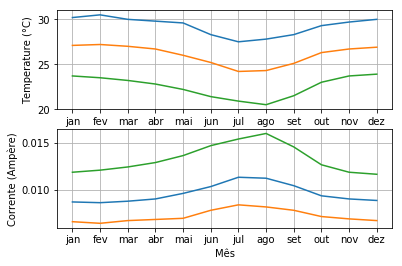

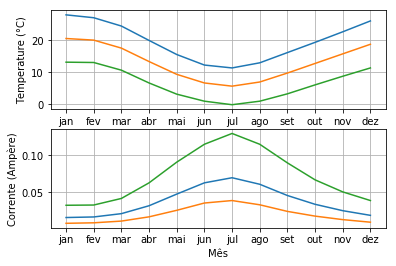

In [13]:
mes=['jan','fev','mar','abr','mai','jun','jul','ago','set','out','nov','dez']

Tc_jpa=[27.1,27.2,27.0,26.7,26.0,25.2,24.2,24.3,25.1,26.3,26.7,26.9]
Tc_jpa_max=[30.2,30.5,30.0,29.8,29.6,28.3,27.5,27.8,28.3,29.3,29.7,30.0]
Tc_jpa_min=[23.7,23.5,23.2,22.8,22.2,21.4,20.9,20.5,21.5,23.0,23.7,23.9]

ic_jpa=[IS*np.exp(vbe1/vt_val(x)) for x in Tc_jpa]
ic_jpa_max=[IS*np.exp(vbe1/vt_val(x)) for x in Tc_jpa_max]
ic_jpa_min=[IS*np.exp(vbe1/vt_val(x)) for x in Tc_jpa_min]

# plt.figure(num=1, figsize=(15,10))
plt.figure(num=1)

plt.subplot(211)
plt.grid(True)
plt.xlabel('Mês')
plt.ylabel('Temperature (\xb0C)')
plt.plot(mes,Tc_jpa_max,mes,Tc_jpa,mes,Tc_jpa_min)

plt.subplot(212)
plt.grid(True)
plt.xlabel('Mês')
plt.ylabel('Corrente (Ampère)')
plt.plot(mes,ic_jpa,mes,ic_jpa_max,mes,ic_jpa_min)

Tc_cbr=[20.6,20.1,17.6,13.4,9.4,6.7,5.7,7.0,9.8,12.8,15.8,18.8]
Tc_cbr_max=[28.0,27.1,24.5,20.0,15.6,12.3,11.4,13.0,16.2,19.4,22.7,26.1]
Tc_cbr_min=[13.2,13.1,10.7,6.7,3.2,1.0,-0.1,1.0,3.3,6.1,8.8,11.4]

ic_cbr=[IS*np.exp(vbe1/vt_val(x)) for x in Tc_cbr]
ic_cbr_max=[IS*np.exp(vbe1/vt_val(x)) for x in Tc_cbr_max]
ic_cbr_min=[IS*np.exp(vbe1/vt_val(x)) for x in Tc_cbr_min]

# plt.figure(num=2, figsize=(15,10))
plt.figure(num=2)

plt.subplot(211)
plt.grid(True)
plt.xlabel('Mês')
plt.ylabel('Temperature (\xb0C)')
plt.plot(mes,Tc_cbr_max,mes,Tc_cbr,mes,Tc_cbr_min)

plt.subplot(212)
plt.grid(True)
plt.xlabel('Mês')
plt.ylabel('Corrente (Ampère)')
plt.plot(mes,ic_cbr,mes,ic_cbr_max,mes,ic_cbr_min)

In [14]:
print('Mínima Corrente em JPA: %(ic)3.6f @ %(temp)3.1f \xb0C'   % {'ic':np.min(ic_jpa), 'temp':np.min(Tc_jpa)})
print('Máxima Corrente em JPA: %(ic)3.6f @ %(temp)3.1f \xb0C\n' % {'ic':np.max(ic_jpa), 'temp':np.max(Tc_jpa)})

print('Mínima Corrente em CBR: %(ic)3.6f @ %(temp)3.1f \xb0C'   % {'ic':np.min(ic_cbr), 'temp':np.min(Tc_cbr)})
print('Máxima Corrente em CBR: %(ic)3.6f @ %(temp)3.1f \xb0C'   % {'ic':np.max(ic_cbr), 'temp':np.max(Tc_cbr)})

Mínima Corrente em JPA: 0.008604 @ 24.2 °C
Máxima Corrente em JPA: 0.011312 @ 27.2 °C

Mínima Corrente em CBR: 0.015825 @ 5.7 °C
Máxima Corrente em CBR: 0.069646 @ 20.6 °C


In [15]:
print('Vbe @ 27\xb0C: %3.6f' % (vt_val(27)*np.log(10e-3/14.3e-15)))
print('Vbe @ 77\xb0C: %3.6f' % (vt_val(77)*np.log(10e-3/14.3e-15)))

Vbe @ 27°C: 0.705423
Vbe @ 77°C: 0.822935


____
## Exemplo 03
### Polarização com resistência de base

Suponha agora que você deve utilizar a polarização com resitor de base no circuito do Exemplo 01. Como fica a variação da corrente Ib para uma resistência de base calculada de 493.887KOhm? Ic = 10mA


In [16]:
Ic = 10e-3
Rb = (vdd - 0.7)*Bf/Ic
print('Rb:',Rb,'Ohm\n')

# O valor de 0.7 volts se refere à polarização de base.
# Perceba que até esse ponto não sabemos exatamente quanto
# deve ser esse valor e assumimos (de acordo com o datasheet)
# que com essa polarização o transistor oferece aproximadamente
# 10mA de corrente Ic. É possível encontrar um valor mais exato
# com utilização de iterações. Mas 0.7, nesse caso, é suficiente.
#
# O cálculo de Rb é dependente de beta do transistor, e portanto,
# a polarização do transitor também é. Nos 'livramos' da temperatura
# Mas o transistor ainda é muito dependentes de beta.

print('- Calculo da corrente Ib0 com resistor de base em 27\xb0C -')
print('- Ic = 10mA -')
vbe1 = vt_val(27)*np.log(Ic/IS)
Ib = (vdd - Vbe1)/Rb
vce1 = vdd - Ic*Rc

# Imprime resultado em tela
print('Ic: %3.6f' % Ic)
print('Vce: %3.6f' % vce1,'\n')
print('Ib: %3.6f' % Ib)
print('Vbe: %3.6f' % Vbe1)

#Calcula a corrente Ib utilizando Bf e imprime o resultado em tela
vcb1=(vce1-vbe1)
B1 = Bf*(1+(vcb1/VA))
Ib=ic/B;

print('\nBeta: %3.6f' % B1)
print('Ib=Ic/Bf: %3.6f' % Ib)


print('\n\n- Calculo da corrente Ib0 com resistor de base em 77\xb0C -')
print('- Ic = 10mA -')
vbe2 = vt_val(77)*np.log(Ic/IS)
Ib = (vdd - Vbe2)/Rb
vce2 = vdd - Ic*Rc

# Imprime resultado em tela
print('Ic: %3.6f' % Ic)
print('Vce: %3.6f' % vce2,'\n')
print('Ib: %3.6f' % Ib)
print('Vbe: %3.6f' % Vbe2,'\n')

#Calcula a corrente Ib utilizando Bf e imprime o resultado em tela
vcb2=(vce2-vbe2)
B2 = Bf*(1+(vcb2/VA))
Ib=ic/B;

print('\nBeta: %3.6f' % B2)
print('Ib=Ic/Bf: %3.6f' % Ib)

Rb: 493887.0 Ohm

- Calculo da corrente Ib0 com resistor de base em 27°C -
- Ic = 10mA -
Ic: 0.010000
Vce: 15.000000 

Ib: 0.000039
Vbe: 0.705423

Beta: 305.312161
Ib=Ic/Bf: 0.000033


- Calculo da corrente Ib0 com resistor de base em 77°C -
- Ic = 10mA -
Ic: 0.010000
Vce: 15.000000 

Ib: 0.000039
Vbe: 0.822935 


Beta: 304.905958
Ib=Ic/Bf: 0.000033


____
E se $\beta_f$ variar na fabricação?

In [17]:
# Ic = 10e-3
Rc = 500
Rb = 493887.0
print('Rb:',Rb,'Ohm\n')

# O cálculo de Rb é dependente de beta do transistor, e portanto,
# a polarização do transitor também é. Nos 'livramos' da temperatura
# Mas o transistor ainda é muito dependentes de beta.

print('- Calculo da corrente Ic0 com resistor de base e variação de beta em 27\xb0C -')
print('- Beta = 200 -')

B1 = 200
Vbe1 = 0.7
Ib = (vdd - Vbe1)/Rb
Ic = Ib*B1 # Corrente Ic definida usando beta e corrente de base
vce = vdd - Ic * Rc

# Imprime resultado em tela
print('Ic: %3.6f' % Ic)
print('Vce: %3.6f' % vce,'\n')
print('Ib: %3.6f' % Ib)
print('Vbe: %3.6f' % Vbe1,'\n')

print('- Calculo da corrente Ic0 com resistor de base e variação de beta em 27\xb0C -')
print('- Beta = 450 -')

B2 = 450
Vbe2 = 0.7
Ib = (vdd - Vbe2)/Rb
Ic = Ib*B2 # Corrente Ic definida usando beta e corrente de base
vce = vdd - Ic * Rc

# Imprime resultado em tela
print('Ic: %3.6f' % Ic)
print('Vce: %3.6f' % vce,'\n')
print('Ib: %3.6f' % Ib)
print('Vbe: %3.6f' % Vbe2,'\n')

Rb: 493887.0 Ohm

- Calculo da corrente Ic0 com resistor de base e variação de beta em 27°C -
- Beta = 200 -
Ic: 0.007816
Vce: 16.092224 

Ib: 0.000039
Vbe: 0.700000 

- Calculo da corrente Ic0 com resistor de base e variação de beta em 27°C -
- Beta = 450 -
Ic: 0.017585
Vce: 11.207503 

Ib: 0.000039
Vbe: 0.700000 



____
## Exemplo 04
### Utilização de resistência de emissor e divisor de tensão na base

Suponha que a tempertatura subiu de 27 para 37 graus. Determine o novo valor de beta

In [18]:
vcc=3
Ic=2e-3

Re  = 500
vre = Re*Ic

vbe27=vt_val(27)*np.log(Ic/IS)
vbe37=vt_val(37)*np.log(Ic/IS)

vb27=vre+vbe27
vb37=vre+vbe37

In [19]:
R1=12000
R2=16800

rthev = R1*R2/(R1+R2)
vthev = vcc*R2/(R1+R2)
B=Bf
Ib=Ic/B

BI = B
BSTOP = 0
ITR = 1000

for i in range(0,ITR):
    Ib = (vthev-vbe37)/(rthev+(1+B)*Re)
    B  = Ic/Ib

    if (BI != np.trunc(B)):
        BI = np.trunc(B)
        BSTOP = 0
    else: BSTOP = BSTOP + 1
    if (BSTOP == 20):
        print('itr: %(itr)3d >> Ib = %(ib)3.9f, Beta = %(beta)4.3f' % {'itr':i, 'ib':Ib, 'beta':B})
        break
    elif (i==ITR-1): print('Beta not found')
    
# for i in range(0,100):
#     B=((((vthev-vbe37)/Ib)-rthev)/Re)-1
#     Ib=Ic/B
#     print('itr : %(itr)3d >> Ib = %(ib)3.6f, Beta = %(beta)4.3f' % {'itr':i, 'ib':Ib, 'beta':B})
    

itr:  70 >> Ib = 0.000008536, Beta = 234.312
